In [1]:
import os
import pandas as pd

# Define the root directory containing the subdirectories
root_dir = '/scratch/grenders95/syft_sboms_largeset'

# Initialize an empty list to store the data
data = []

# Iterate over each subdirectory in the root directory
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # Define the path to the syft_sbom.json file
        sbom_file_path = os.path.join(subdir_path, 'cleaned_sbomv2.json')
        try:
            # Open the syft_sbom.json file and read its contents
            with open(sbom_file_path, 'r') as file:
                sbom_content = file.read()
            # Append the directory name and SBOM content to the data list
            data.append({'org_repo_name': subdir, 'syft_sbom': sbom_content})
        except FileNotFoundError:
            print(f"SBOM file not found in {subdir_path}")

# Create a DataFrame from the collected data
df_syft = pd.DataFrame(data)

# Display the DataFrame
print(df_syft)


                          org_repo_name  \
0                        hackndo_lsassy   
1                          thudm_webglm   
2                      lucksi_mr.holmes   
3                         gleitz_howdoi   
4               paddlepaddle_paddleslim   
..                                  ...   
411                      chubin_wttr.in   
412                   sshuttle_sshuttle   
413  coddingtonbear_python-myfitnesspal   
414                 amueller_word_cloud   
415             nemesida-waf_waf-bypass   

                                             syft_sbom  
0    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...  
1    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...  
2    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...  
3    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...  
4    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...  
..                                                 ...  
411  {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...  
412  {\n  "spdxVersion": "S

In [3]:
from datasets import load_from_disk

dataset_dict = load_from_disk('/home/grenders95/710/710_project/data/training/hf_datasets/newreqs_clearedfields')

test_dataset = dataset_dict['test']

In [4]:
print(test_dataset)

Dataset({
    features: ['org_repo_name', 'requirements', 'sbom', 'mod_manifest_newreqs', 'num_dependencies', 'sbom_data_cleared', '__index_level_0__'],
    num_rows: 532
})


In [5]:
from datasets import Dataset

df_test = test_dataset.to_pandas()

In [6]:

df_merged = pd.merge(df_syft, df_test, on='org_repo_name', how='left')



                          org_repo_name  \
0                        hackndo_lsassy   
1                          thudm_webglm   
2                      lucksi_mr.holmes   
3                         gleitz_howdoi   
4               paddlepaddle_paddleslim   
..                                  ...   
411                      chubin_wttr.in   
412                   sshuttle_sshuttle   
413  coddingtonbear_python-myfitnesspal   
414                 amueller_word_cloud   
415             nemesida-waf_waf-bypass   

                                             syft_sbom  \
0    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...   
1    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...   
2    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...   
3    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...   
4    {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...   
..                                                 ...   
411  {\n  "spdxVersion": "SPDX-2.3",\n  "dataLicens...   
412  {\n  "spdxVers

In [8]:
import json

def flatten_sbom_json(row, column_name):
    sbom_data = row[column_name]
    if isinstance(sbom_data, str):
        try:
            sbom_data = json.loads(sbom_data)
        except json.JSONDecodeError:
            return 'Invalid JSON'
    elif not isinstance(sbom_data, dict):
        return 'Unsupported data format'
    
    flattened = []

    try:
        for key, value in sbom_data.items():
            if key != 'packages':  
                flattened.append(f'creation/{key}: {value}')
            else:
                for package in value:
                    for p_key, p_value in package.items():
                        flattened.append(f'packages/{p_key}: {p_value}')
    except AttributeError:
        return 'Error processing JSON structure'
    
    return '\n'.join(flattened)

def apply_flatten_sbom(df, source_column, target_column):
    df.loc[:, target_column] = df.apply(lambda row: flatten_sbom_json(row, source_column), axis=1)

apply_flatten_sbom(df_merged, 'syft_sbom', 'flattened_syft_sbom')
apply_flatten_sbom(df_merged, 'sbom', 'flattened_gt_sbom')


In [10]:
fields_of_interest = [
    "creation/name", "creation/dataLicense", 
    "packages/name", "packages/versionInfo", 
    "packages/downloadLocation", "packages/licenseDeclared", 
    "packages/licenseConcluded"
]

def parse_fields_to_dict(sbom_text, specific_fields):
    """Parse specified field keys from the flattened SBOM text and count their occurrences."""
    fields_dict = {field: 0 for field in specific_fields}  # Initialize dict with 0 to count occurrences
    
    if pd.isna(sbom_text):  
        return fields_dict
    
    for line in sbom_text.split('\n'):
        if line.strip():  
            field_key = line.split(':')[0].strip() 
            if field_key in fields_dict:
                fields_dict[field_key] += 1  
    
    return fields_dict

def calculate_precision_recall_for_sboms(gen_sbom_text, gt_sbom_text, specific_fields):
    gen_fields_dict = parse_fields_to_dict(gen_sbom_text, specific_fields)
    gt_fields_dict = parse_fields_to_dict(gt_sbom_text, specific_fields)
    
    tp, fp, fn = 0, 0, 0
    
    # Iterate over the specific fields to calculate TP, FP, and FN based on occurrences
    for field in specific_fields:
        if gen_fields_dict[field] > 0 and gt_fields_dict[field] > 0:
            tp += min(gen_fields_dict[field], gt_fields_dict[field])
            fp += max(gen_fields_dict[field] - gt_fields_dict[field], 0)
            fn += max(gt_fields_dict[field] - gen_fields_dict[field], 0)
        elif gen_fields_dict[field] > 0:
            fp += gen_fields_dict[field]
        elif gt_fields_dict[field] > 0:
            fn += gt_fields_dict[field]
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

df_merged['precision_syft_field'], df_merged['recall_syft_field'] = zip(*df_merged.apply(lambda row: calculate_precision_recall_for_sboms(row['flattened_syft_sbom'], row['flattened_gt_sbom'], fields_of_interest), axis=1))

In [11]:
average_precision_fields = df_merged['precision_syft_field'].mean()
average_recall_fields = df_merged['recall_syft_field'].mean()
data_points = len(df_merged)

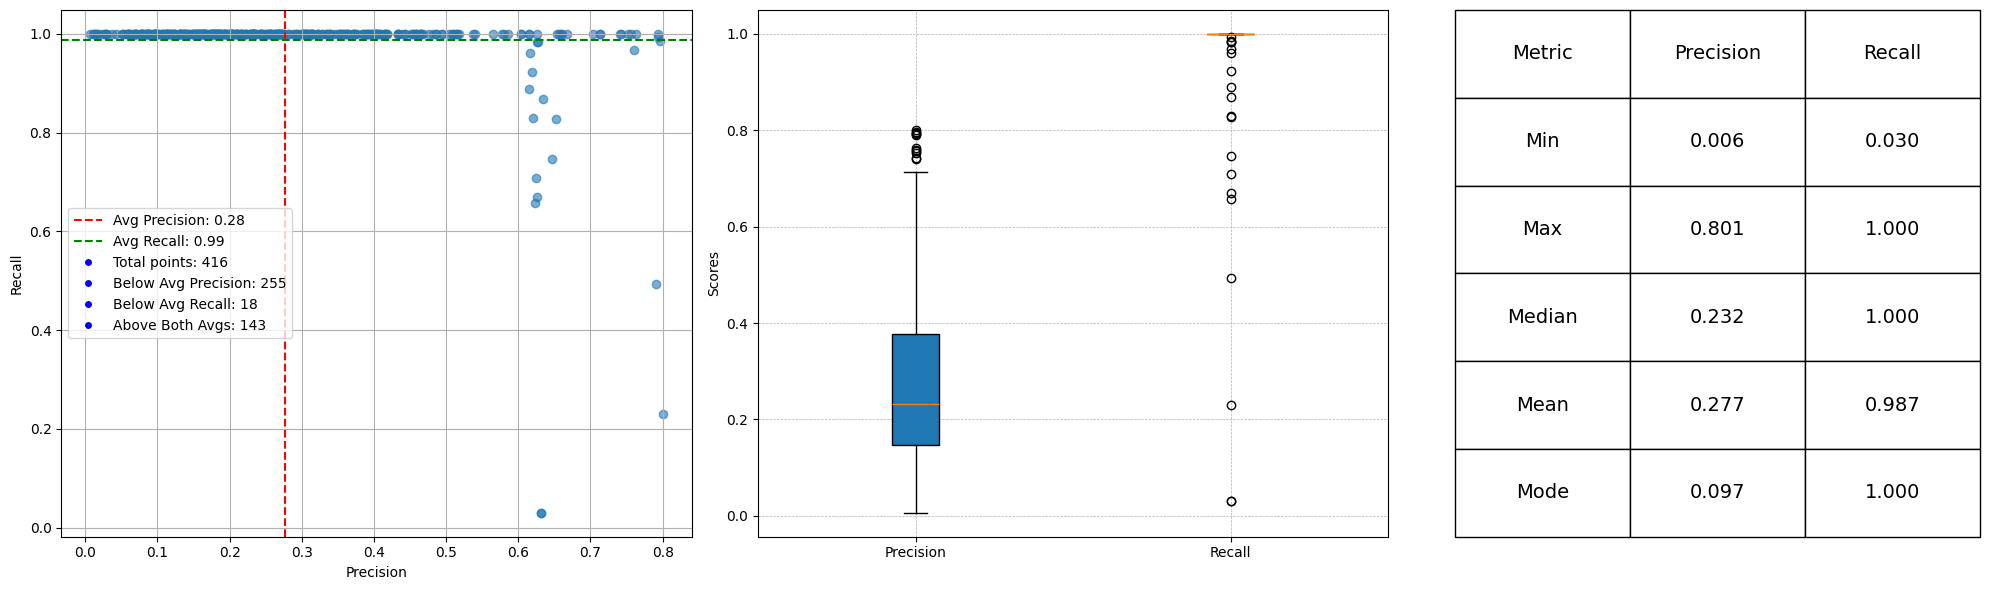

In [12]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import mode
import numpy as np

def create_plots_with_table_and_boxplot_field(dataframe, avg_precision, avg_recall, data_points, save_path):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[3, 3, 2.5])

    # Scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(dataframe['precision_syft_field'], dataframe['recall_syft_field'], alpha=0.6)
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.axvline(x=avg_precision, color='r', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
    ax1.axhline(y=avg_recall, color='g', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')

    # Calculate additional metrics for the legend
    points_below_avg_precision = dataframe[dataframe['precision_syft_field'] < avg_precision].shape[0]
    points_below_avg_recall = dataframe[dataframe['recall_syft_field'] < avg_recall].shape[0]
    points_above_both = dataframe[(dataframe['precision_syft_field'] > avg_precision) & (dataframe['recall_syft_field'] > avg_recall)].shape[0]

    # Create custom legend entries
    custom_lines = [mlines.Line2D([], [], color='r', linestyle='--', markersize=15, label=f'Avg Precision: {avg_precision:.2f}'),
                    mlines.Line2D([], [], color='g', linestyle='--', markersize=15, label=f'Avg Recall: {avg_recall:.2f}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Total points: {data_points}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Precision: {points_below_avg_precision}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Recall: {points_below_avg_recall}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Above Both Avgs: {points_above_both}')]

    # Add the custom legend to the plot
    ax1.legend(handles=custom_lines, loc='center left')

    # Box plot
    ax2 = fig.add_subplot(gs[1])
    ax2.boxplot(
        [dataframe['precision_syft_field'], dataframe['recall_syft_field']],
        patch_artist=True,
        labels=['Precision', 'Recall']
    )
    ax2.set_ylabel('Scores')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Prepare data for the table
    stats_precision = get_statistics(dataframe['precision_syft_field'].dropna())
    stats_recall = get_statistics(dataframe['recall_syft_field'].dropna())

    # Table data
    table_data = [
        ["Min", stats_precision[0], stats_recall[0]],
        ["Max", stats_precision[1], stats_recall[1]],
        ["Median", stats_precision[2], stats_recall[2]],
        ["Mean", stats_precision[3], stats_recall[3]],
        ["Mode", stats_precision[4] or "N/A", stats_recall[4] or "N/A"]
    ]

    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    table = ax3.table(cellText=table_data, colLabels=['Metric', 'Precision', 'Recall'], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def format_statistic(value):
    if value is None or (isinstance(value, np.ndarray) and value.size == 0):
        return "N/A"
    return f"{value:.3f}"

def get_statistics(column):
    mode_result = mode(column, nan_policy='omit')
    mode_val = mode_result.mode if mode_result.mode.size > 0 else None
    return [
        format_statistic(np.min(column)),
        format_statistic(np.max(column)),
        format_statistic(np.median(column)),
        format_statistic(np.mean(column)),
        format_statistic(mode_val)
    ]

create_plots_with_table_and_boxplot_field(df_merged, average_precision_fields, average_recall_fields, data_points, '/home/grenders95/710/710_project/data/figures/eval/syft_big_set/2syft_scatter_box_field.png')

In [13]:
def parse_fields_to_dict(sbom_text, fields_of_interest, adjust=False):
    """Parse specific field keys from the flattened SBOM text into a dictionary, optionally adjusting field values."""
    fields_dict = {}
    for line in sbom_text.split('\n'):
        if line.strip():
            field_key, _, value = line.partition(':')
            field_key = field_key.strip()
            value = value.strip()
            if field_key in fields_of_interest:
                if adjust:
                    value = adjust_field_value(field_key, value, is_gt=True)
                if field_key in fields_dict:
                    fields_dict[field_key].append(value)
                else:
                    fields_dict[field_key] = [value]
    return fields_dict

def adjust_field_value(field_key, value, is_gt):
    """Adjust field values based on specified rules, including handling for 'packages/name'."""
    if field_key == "packages/name" and ':' in value:
        return value.split(':', 1)[1].strip()
    return value

def compare_field_values(gen_value, gt_value, field_key):
    """Compare field values, considering special cases for NOASSERTION and empty values."""
    gen_value = adjust_field_value(field_key, gen_value, is_gt=False)
    gt_value = adjust_field_value(field_key, gt_value, is_gt=True)
    
    if field_key in ["packages/downloadLocation", "packages/licenseDeclared", "packages/licenseConcluded"]:
        if (gen_value == "NOASSERTION" and not gt_value) or (gen_value == gt_value):
            return True
    else:
        if gen_value == gt_value:
            return True
    return False

def calculate_precision_recall_value_based(gen_sbom_text, gt_sbom_text, fields_of_interest):
    """Calculate precision and recall focusing on field values for specified fields."""
    gen_fields_dict = parse_fields_to_dict(gen_sbom_text, fields_of_interest, adjust=False)  
    gt_fields_dict = parse_fields_to_dict(gt_sbom_text, fields_of_interest, adjust=True) 

    tp, fp, fn = 0, 0, 0

    for field in gen_fields_dict:
        for gen_value in gen_fields_dict[field]:
            if field in gt_fields_dict:
                matched = False
                for gt_value in gt_fields_dict[field]:
                    if compare_field_values(gen_value, gt_value, field):
                        tp += 1
                        matched = True
                        break  
                if not matched:
                    fp += 1  
            else:
                fp += len(gen_fields_dict[field])  

    for field in gt_fields_dict:
        if field not in gen_fields_dict:
            fn += len(gt_fields_dict[field])  
        else:
            for gt_value in gt_fields_dict[field]:
                if all(not compare_field_values(gen_value, gt_value, field) for gen_value in gen_fields_dict.get(field, [])):
                    fn += 1  

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

In [14]:

fields_of_interest = [
    "creation/dataLicense", "packages/name", "packages/versionInfo",
    "packages/downloadLocation", "packages/licenseDeclared",
    "packages/licenseConcluded"
]

df_merged[['precision_syft_value', 'recall_syft_value']] = df_merged.apply(
    lambda row: calculate_precision_recall_value_based(row['flattened_syft_sbom'], row['flattened_gt_sbom'], fields_of_interest),
    axis=1, result_type='expand'
)

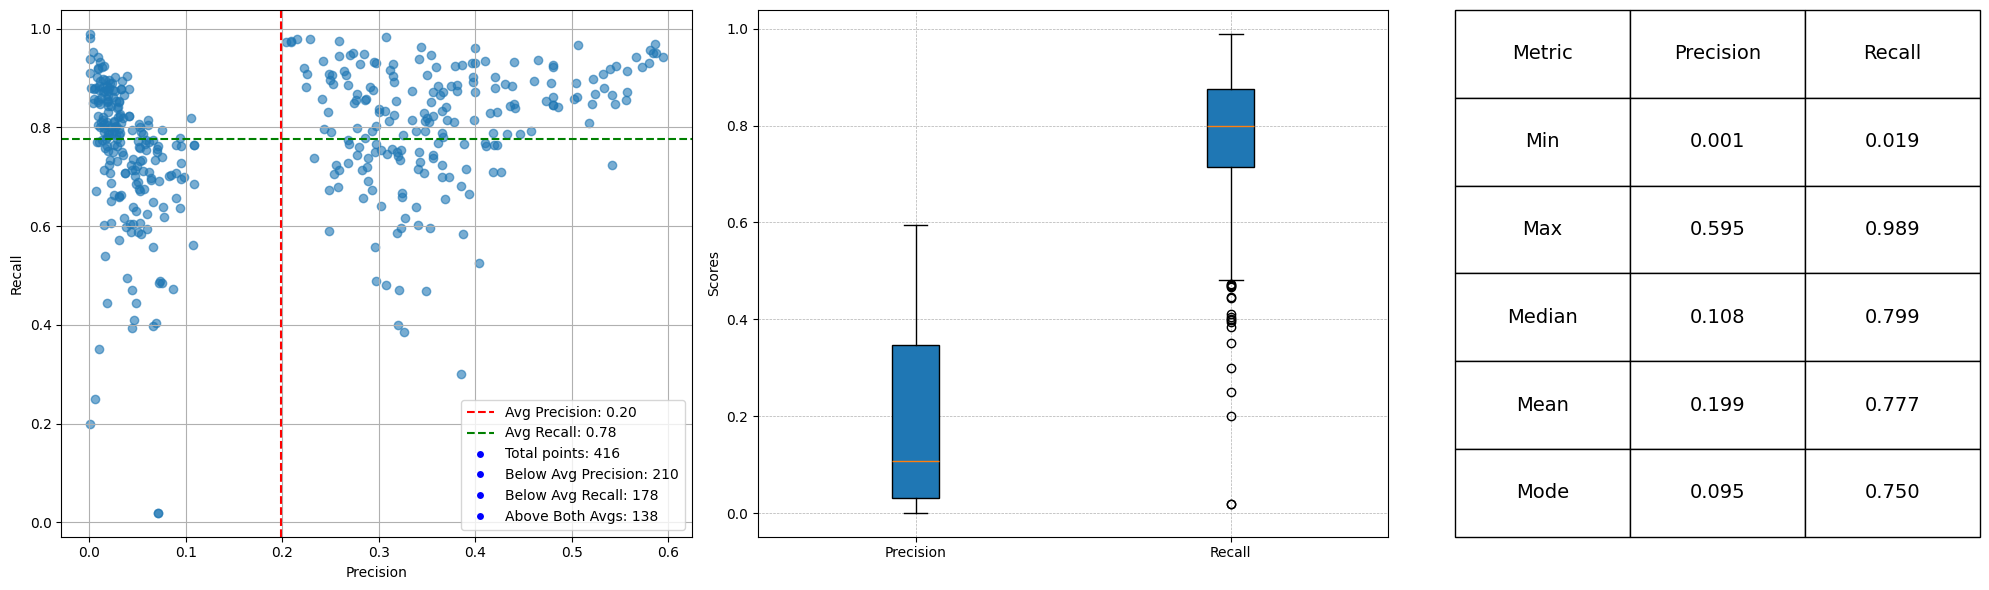

In [15]:
average_precision_values = df_merged['precision_syft_value'].mean()
average_recall_values = df_merged['recall_syft_value'].mean()
data_points = len(df_merged)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import mode
import numpy as np

def create_plots_with_table_and_boxplot_value(dataframe, avg_precision, avg_recall, data_points, save_path):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[3, 3, 2.5])

    # Scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(dataframe['precision_syft_value'], dataframe['recall_syft_value'], alpha=0.6)
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.axvline(x=avg_precision, color='r', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
    ax1.axhline(y=avg_recall, color='g', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')

    # Calculate additional metrics for the legend
    points_below_avg_precision = dataframe[dataframe['precision_syft_value'] < avg_precision].shape[0]
    points_below_avg_recall = dataframe[dataframe['recall_syft_value'] < avg_recall].shape[0]
    points_above_both = dataframe[(dataframe['precision_syft_value'] > avg_precision) & (dataframe['recall_syft_value'] > avg_recall)].shape[0]

    # Create custom legend entries
    custom_lines = [mlines.Line2D([], [], color='r', linestyle='--', markersize=15, label=f'Avg Precision: {avg_precision:.2f}'),
                    mlines.Line2D([], [], color='g', linestyle='--', markersize=15, label=f'Avg Recall: {avg_recall:.2f}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Total points: {data_points}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Precision: {points_below_avg_precision}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Recall: {points_below_avg_recall}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Above Both Avgs: {points_above_both}')]

    # Add the custom legend to the plot
    ax1.legend(handles=custom_lines, loc='lower right')

    # Box plot
    ax2 = fig.add_subplot(gs[1])
    ax2.boxplot(
        [dataframe['precision_syft_value'], dataframe['recall_syft_value']],
        patch_artist=True,
        labels=['Precision', 'Recall']
    )
    ax2.set_ylabel('Scores')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Prepare data for the table
    stats_precision = get_statistics(dataframe['precision_syft_value'].dropna())
    stats_recall = get_statistics(dataframe['recall_syft_value'].dropna())

    # Table data
    table_data = [
        ["Min", stats_precision[0], stats_recall[0]],
        ["Max", stats_precision[1], stats_recall[1]],
        ["Median", stats_precision[2], stats_recall[2]],
        ["Mean", stats_precision[3], stats_recall[3]],
        ["Mode", stats_precision[4] or "N/A", stats_recall[4] or "N/A"]
    ]

    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    table = ax3.table(cellText=table_data, colLabels=['Metric', 'Precision', 'Recall'], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def format_statistic(value):
    if value is None or (isinstance(value, np.ndarray) and value.size == 0):
        return "N/A"
    return f"{value:.3f}"

def get_statistics(column):
    mode_result = mode(column, nan_policy='omit')
    mode_val = mode_result.mode if mode_result.mode.size > 0 else None
    return [
        format_statistic(np.min(column)),
        format_statistic(np.max(column)),
        format_statistic(np.median(column)),
        format_statistic(np.mean(column)),
        format_statistic(mode_val)
    ]

create_plots_with_table_and_boxplot_value(df_merged, average_precision_values, average_recall_values, data_points, '/home/grenders95/710/710_project/data/figures/eval/syft_big_set/2syft_scatter_box_value.png')

In [16]:
# Save to csv

df_merged.to_csv('/home/grenders95/710/710_project/data/figures/eval/syft_big_set/syft_bigset_eval.csv', index=False)